# MLP using Keras & Scikit-Optimize: Sonar an Thyroid Datasets
##### Partial Sources: Scikit-Optimize __[Source](https://scikit-optimize.github.io/auto_examples/visualizing-results.html)__ | Aayush Agrawal  __[Source](https://github.com/aayushmnit/Deep_learning_explorations)__

In this notebook, we are going to build an MLP neural network using `Keras`, `Tensorflow` and successfully train it to recognize digits in the very popular __[MNIST](https://en.wikipedia.org/wiki/MNIST_database)__ dataset images. 

__[Keras](https://keras.io)__ is a high-level neural networks API, written in Python and capable of running on top of __[TensorFlow](https://www.tensorflow.org)__ (developed by Google), __[CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/)__ (developed by Microsoft), or __[Theano](http://deeplearning.net/software/theano/)__. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

__[TensorFlow](https://www.tensorflow.org)__ is a very popular deep learning framework and is the default backend for Keras. 

This notebook is a guide for building an MLP neural network using Keras and TensorFlow backend.

As for hyper-parameter turning, we shall rely on __[Scikit-Optimize](https://scikit-optimize.github.io/index.html)__.

Let's start by importing our data. As keras, a high-level deep learning library already has MNIST as part of their default data we are just going to import the dataset from there and split it into train and test set.

In [1]:
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
## Importing required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline
import pandas as pd
df = pd.read_csv('sonar.csv', header=None)
X_test = df.sample(frac=0.20, replace=True, random_state=1)
Y_test = X_test[60]
X_test.drop([60],axis=1, inplace=True)
X_test.head()
X_train = df.drop(X_test.index)
Y_train = X_train[60]
X_train.drop([60],axis=1, inplace=True)
X_train.head()
#X_test.head()


Using TensorFlow backend.


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062


In [2]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
print("X_test shape: ",X_test.shape)
print("X_train shape: ",X_train.shape)

X_test shape:  (42, 60)
X_train shape:  (168, 60)


In [3]:
X_test.describe()
#X_train.iloc[1]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.341999,0.226467,0.122818,0.142870,-0.167060,-0.128013,0.044257,0.076250,0.169687,0.217953,...,0.462416,0.314813,0.388526,0.427595,0.196631,0.145083,-0.157758,0.086647,0.073810,0.146344
std,1.389765,1.152497,1.057326,0.971291,0.767033,0.918535,1.175265,1.097005,1.111077,1.317890,...,2.041536,1.532263,1.226465,1.315611,1.189448,1.023224,0.854839,1.151823,1.202163,1.281186
min,-1.158306,-1.143732,-1.069626,-1.005342,-1.102242,-1.510999,-1.807950,-1.488041,-1.445978,-1.283082,...,-1.448069,-1.264024,-1.193731,-1.353417,-1.175392,-1.347383,-1.300522,-1.164563,-1.297403,-1.185315
25%,-0.530173,-0.771546,-0.691472,-0.615098,-0.685100,-0.713297,-0.812222,-0.609940,-0.593405,-0.670202,...,-0.761153,-0.638893,-0.523945,-0.578396,-0.739957,-0.556589,-0.802847,-0.742052,-0.532959,-0.817356
50%,-0.101523,0.014524,-0.280831,-0.114566,-0.263653,-0.188449,-0.298406,-0.342065,-0.138411,-0.165967,...,-0.122536,-0.049146,0.168293,0.137293,-0.083116,-0.196339,-0.448570,-0.223878,-0.334457,-0.418303
75%,0.713032,0.915648,0.943946,0.613431,-0.026024,0.192045,0.764487,0.742047,0.789275,0.591452,...,0.918571,0.552396,0.692148,1.305387,0.717641,0.937133,0.441340,0.657018,0.324401,0.841048
max,5.182397,2.704768,2.628746,2.392332,1.738973,3.360325,3.551852,3.907895,3.379372,3.926500,...,9.134730,6.839099,4.299267,3.556284,4.212186,2.958050,2.073544,4.750595,4.818150,3.188726


Plot some sample images along with their labels.

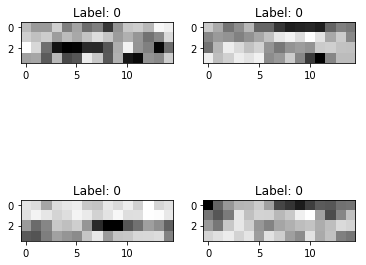

In [4]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%Y_train.iloc[i])
    plt.imshow(X_train.iloc[i].values.reshape(4,15),cmap='Greys');

In [5]:
## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(Y_train)
y_test_one_hot = lb.transform(Y_test)
print('Train labels dimension:');print(y_train_one_hot.shape)
print('Test labels dimension:');print(y_test_one_hot.shape)

Train labels dimension:
(168, 1)
Test labels dimension:
(42, 1)


Now we have processed the data, let's start building our multi-layer perceptron using tensorflow. We will begin by importing the required libraries.

In [6]:
## Importing required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

### Define & Compile Keras Model for Hyper-Parameter Optimization
Models in Keras are defined as a sequence of layers. We create a `Sequential` model and add layers one at a time until we are happy with our network architecture.

The first thing to get right is to ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument and setting it to 784 for the 784 input pixels.

In this example, we will use a fully-connected network structure with three layers.

Fully connected layers are defined using the `Dense` class. We can specify the number of neurons or nodes in the layer as the first argument, and specify the activation function using the activation argument.

We will use the rectified linear unit activation function referred to as `ReLU` on the first two layers and the `Sigmoid` function in the output layer.

We can piece it all together by adding each layer:
The model expects rows of data with 784 variables (the input_dim=784 argument)
The first hidden layer has num_layers_0 = 512 nodes and uses the relu activation function.
The second hidden layer has num_layers_1 = 256 nodes and uses the relu activation function.
The output layer has 10 nodes for the ten digits/classes.

Let's start our model construction by defining initialization variables.

In [7]:
# Defining various initialization parameters for MLP model
num_features = X_train.shape[1]; num_classes = y_train_one_hot.shape[1] 

# Let's create a helper function first which builds the model with various parameters.
def get_model(dense_0_neurons, dense_1_neurons, dropout_rate, input_dim, num_classes):
    # Builds a Sequential MLP model using Keras and returns it
    
    # Define the keras model
    model = Sequential()
    model.add(Dense(dense_0_neurons, input_dim=input_dim, activation='relu', name="dense_1"))
    model.add(Dense(dense_1_neurons, activation='relu', name="dense_2"))
    model.add(Dropout(dropout_rate, name="dropout"))
    model.add(Dense(num_classes, activation='sigmoid', name="dense_3"))
    return model

### Setup Keras Model for Scikit-Optimizer

In [8]:
import skopt
from skopt import gp_minimize

# Specify `Static' Parameters
STATIC_PARAMS = {num_features, num_classes}

# Bounded region of parameter space
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the dropout_rate)
SPACE = [skopt.space.Integer(8, 512, name='dense_0_neurons'),
         skopt.space.Integer(16, 512, name='dense_1_neurons'),
        skopt.space.Real(0.0, 0.6, name='dropout_rate')]

# This decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters         
@skopt.utils.use_named_args(SPACE)
         
# Define objective for optimization
def objective(**params):
  
    # All parameters: 
    #all_params = {**params, **STATIC_PARAMS}
    
    # Create the model using a specified hyperparameters.
    #model = get_model(all_params)
    model = get_model(params["dense_0_neurons"], params["dense_1_neurons"], params["dropout_rate"], num_features, num_classes)

    # Compile the keras model for a specified number of epochs.
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit keras model
    history = model.fit(X_train, y_train_one_hot, epochs=1, batch_size=8, 
                        validation_split = 0.20, verbose=1)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=1)
    print('Test loss:', score[0], '   Test accuracy:', score[1])

    # Return the accuracy.
    return -1.0 * score[1]

### Run Scikit-Optimizer
There are several methods for optimization: https://scikit-optimize.github.io/modules/minimize_functions.html#minimize-functions

In [39]:
import warnings
warnings.filterwarnings('ignore')

results_gp = skopt.gbrt_minimize(objective,     # the function to minimize
                          SPACE,              # the bounds on each dimension of x
                          x0=[100,50,0],      # the starting point
                          acq_func="LCB",     # the acquisition function (optional)
                          n_calls=50,         # the number of evaluations of f including at x0
                          n_random_starts=4,  # the number of random initialization points
                          random_state=0)

Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 253us/step
Test loss: 0.4769649165017264    Test accuracy: 0.7380952380952381
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 261us/step
Test loss: 0.571174993401482    Test accuracy: 0.6666666666666666
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 285us/step
Test loss: 0.6084313562938145    Test accuracy: 0.6666666666666666
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 285us/step
Test loss: 0.6015413715725854    Test accuracy: 0.6666666666666666
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 342us/step
Test loss: 0.5013108253479004    Test accuracy: 0.7142857142857143
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 320us/step
Test l

#### Get Best Parameter Set

In [60]:
print("Best score=%.4f" % results_gp.fun)

print("""Best parameters:
- dense_0_neurons=%d
- dense_1_neurons=%d
- dropout_rate=%.6f""" % 
      (results_gp.x[0], results_gp.x[1],
                            results_gp.x[2]))

Best score=-0.8571
Best parameters:
- dense_0_neurons=423
- dense_1_neurons=39
- dropout_rate=0.063027


#### Convergence Plot

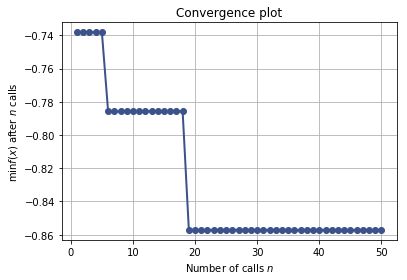

In [61]:
from skopt.plots import plot_convergence
plot_convergence(results_gp)

#### Evaluations Plot
plots.plot_evaluations creates a grid of size n_dims by n_dims. The diagonal shows histograms for each of the dimensions. In the lower triangle (just one plot in this case) a two dimensional scatter plot of all points is shown. The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process.

You should be able to see that points start clustering around the location of the true miminum. The histograms show that the objective is evaluated more often at locations near to one of the three minima.

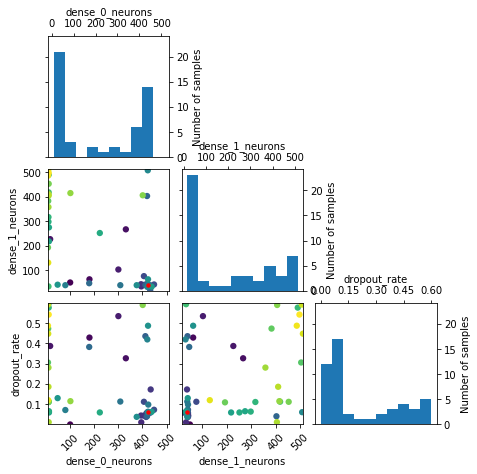

In [62]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(results_gp, bins=10)

#### Objective Partial Dependence Plots
Partial dependence plots were proposed by [Friedman (2001)] as a method for interpreting the importance of input features used in gradient boosting machines. The idea is to visualize how the value of $i$-th variable $x_i$ influences the function $f$ after averaging out the influence of all other variables.For more details see: https://christophm.github.io/interpretable-ml-book/pdp.html

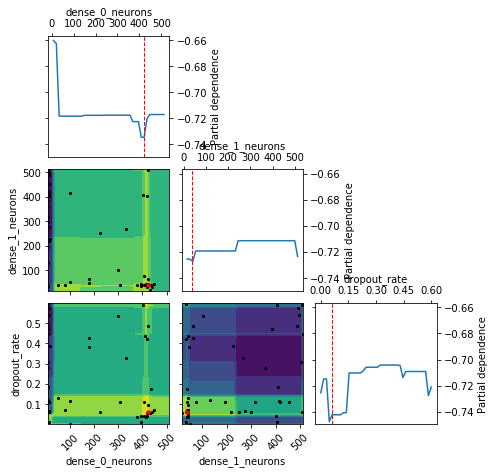

In [63]:
from skopt.plots import plot_objective
_ = plot_objective(results_gp)

### Learn Further using Best Hyper-parameter Settings

In [64]:
# Create the model using a specified hyperparameters.

# Get best hyper-parameters
dense_0_neurons=results_gp.x[0]; dense_1_neurons=results_gp.x[1]; dropout_rate=results_gp.x[2]

# Build 
model = get_model(dense_0_neurons, dense_1_neurons, dropout_rate, num_features, num_classes)

# Compile the keras model for a specified number of epochs.
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit keras model
history = model.fit(X_train, y_train_one_hot, epochs=16, batch_size=8, 
                        validation_split = 0.20, verbose=1)

# Evaluate the model with the eval dataset.
score = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=1)
print('Test loss:', score[0], '   Test accuracy:', score[1])

Train on 134 samples, validate on 34 samples
Epoch 1/16
134/134 [==============================] - 6s 47ms/step - loss: 0.6013 - acc: 0.6194 - val_loss: 1.1184 - val_acc: 0.2647
Epoch 2/16
134/134 [==============================] - 0s 680us/step - loss: 0.3366 - acc: 0.8731 - val_loss: 1.0387 - val_acc: 0.3824
Epoch 3/16
134/134 [==============================] - 0s 726us/step - loss: 0.2349 - acc: 0.9328 - val_loss: 0.9253 - val_acc: 0.4412
Epoch 4/16
134/134 [==============================] - 0s 688us/step - loss: 0.1680 - acc: 0.9925 - val_loss: 0.9925 - val_acc: 0.4706
Epoch 5/16
134/134 [==============================] - 0s 684us/step - loss: 0.1064 - acc: 1.0000 - val_loss: 0.9422 - val_acc: 0.5000
Epoch 6/16
134/134 [==============================] - 0s 742us/step - loss: 0.0726 - acc: 1.0000 - val_loss: 0.8978 - val_acc: 0.5000
Epoch 7/16
134/134 [==============================] - 0s 703us/step - loss: 0.0496 - acc: 1.0000 - val_loss: 0.8663 - val_acc: 0.5588
Epoch 8/16
134/134

### Check Training History
In this section, we will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting. Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [65]:
# Define function for plotting history
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss', 'acc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

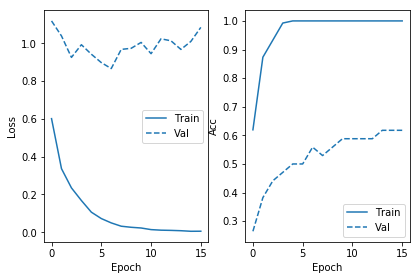

In [66]:
# Plot the training/validation history of our Keras model
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

### Evaluate Metrics
You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [67]:
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion Matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

Evaluate your model on the test dataset and display the evaluation metrics and the confusion matrix.

loss :  0.4240502902927498
acc :  0.8333333333333334



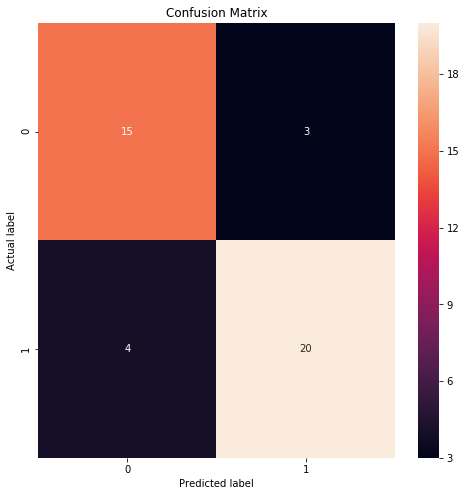

In [68]:
y_test_predictions = model.predict_classes(X_test, batch_size=8)
baseline_results = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_test, y_test_predictions)

### Conclusion
As we can see we have successfully trained a Multi-Layer perceptron which was written in Keras using TensorFlow backend with high validation accuracy!